# Imports

In [1]:
import numpy as np
import pandas as pd
import os

from skimage.transform import resize   # Image Processing Library
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc    # Garbage Collector
gc.collect()

import random

import os

# Pytorch

import sklearn

import torch
import torchvision

from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor

from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange

from torchsummary import summary

import PIL

# Preparation of Dataset

In [2]:
# Input data files (dogs_and_cats) are available in the "../data/dogs_and_cats/" directory.
print(os.listdir("../data/normal_tumor"))

['NORMAL', 'TUMOR']


In [3]:
print(os.listdir("../data/normal_tumor/"))

['NORMAL', 'TUMOR']


In [4]:
IMAGE_SIZE = 150

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

In [5]:
# Generation of Dataset using the Folder containing Images

dataset = datasets.ImageFolder(
    root="../data/normal_tumor/", 
    transform=data_transforms      # Need this to convert PIL image to tensor
)

In [6]:
len(dataset)

4375

In [7]:
next(iter(dataset))

(tensor([[[0.6353, 0.5647, 0.5294,  ..., 0.6431, 0.8157, 0.9725],
          [0.5216, 0.4353, 0.3882,  ..., 0.6275, 0.8235, 0.9765],
          [0.4235, 0.4157, 0.4471,  ..., 0.6431, 0.8431, 0.9686],
          ...,
          [0.9490, 0.9490, 0.9451,  ..., 0.6824, 0.6980, 0.6902],
          [0.9490, 0.9529, 0.9529,  ..., 0.7255, 0.7216, 0.7373],
          [0.9412, 0.9451, 0.9490,  ..., 0.7569, 0.8118, 0.8196]],
 
         [[0.5451, 0.4627, 0.4118,  ..., 0.5843, 0.7922, 0.9490],
          [0.4039, 0.3255, 0.2863,  ..., 0.5804, 0.8078, 0.9608],
          [0.2902, 0.2824, 0.3412,  ..., 0.5961, 0.8196, 0.9451],
          ...,
          [0.9412, 0.9412, 0.9412,  ..., 0.5765, 0.5647, 0.5569],
          [0.9451, 0.9451, 0.9451,  ..., 0.5843, 0.5843, 0.6000],
          [0.9451, 0.9451, 0.9451,  ..., 0.6000, 0.6745, 0.6784]],
 
         [[0.6235, 0.5608, 0.5529,  ..., 0.7373, 0.8000, 0.9569],
          [0.5451, 0.4745, 0.4627,  ..., 0.7216, 0.8039, 0.9569],
          [0.4863, 0.4784, 0.5020,  ...,

# Preparation of Train/Valid/Test Loader

In [8]:
BATCH_SIZE = 5
TEST_SPLIT = 0.1
VALIDATION_SPLIT = 0.2
SHUFFLE_DATASET = True
RANDOM_SEED = 42
# WIDTH = 128
# HEIGHT = 128

In [9]:
# Train/Test Split

dataset_size = len(dataset)
indices = list(range(dataset_size))
test_split = int(np.floor(TEST_SPLIT * dataset_size)+3)   # To match train/valid/test divisible by 10
if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = indices[test_split:], indices[:test_split]

# Train/Validation Split
train_size = len(train_indices)
valid_split = int(np.floor(VALIDATION_SPLIT * train_size)+3)
if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(train_indices)
train_indices, val_indices = train_indices[valid_split:], train_indices[:valid_split]


# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, 
                          sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                          sampler=valid_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                         sampler=valid_sampler)

In [10]:
len(train_sampler)

3145

In [11]:
len(valid_sampler)

790

In [12]:
len(test_sampler)

440

In [13]:
# Sample Image and Annotation

sample_img, sample_label = next(iter(train_loader))

In [14]:
sample_img[0].shape

torch.Size([3, 150, 150])

In [15]:
sample_label[0]

tensor(1)

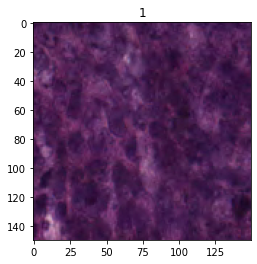

In [16]:
plt.imshow(sample_img[0].permute(1, 2, 0));
plt.title(f"{sample_label[0]}");

# Preparation of CNN

In [17]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 3, (3, 3), padding=1),         # 3, 150 x 150
            nn.ReLU(),
            nn.MaxPool2d((10, 10)),                        # 3, 15 x 15
            #nn.Dropout(0.2),
            nn.Conv2d(3, 1, (3, 3), padding=1),         #  1, 15 x 15
            nn.ReLU(),
            nn.MaxPool2d((5, 5)),                        #  1,  3 x 3
            #nn.Dropout(0.2),
            nn.Flatten(),                                #  9
            nn.Linear(9, 1)
        )

    def forward(self, x):
        logits = self.main(x)
        return logits

In [18]:
model = ConvolutionalNeuralNetwork()

In [19]:
summary(model, (3, 150, 150), device='cpu');

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 3, 150, 150]         84
|    └─ReLU: 2-2                         [-1, 3, 150, 150]         --
|    └─MaxPool2d: 2-3                    [-1, 3, 15, 15]           --
|    └─Conv2d: 2-4                       [-1, 1, 15, 15]           28
|    └─ReLU: 2-5                         [-1, 1, 15, 15]           --
|    └─MaxPool2d: 2-6                    [-1, 1, 3, 3]             --
|    └─Flatten: 2-7                      [-1, 9]                   --
|    └─Linear: 2-8                       [-1, 1]                   10
Total params: 122
Trainable params: 122
Non-trainable params: 0
Total mult-adds (M): 1.83
Input size (MB): 0.26
Forward/backward pass size (MB): 0.52
Params size (MB): 0.00
Estimated Total Size (MB): 0.77


# Model Training

In [20]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        train_batch_acc = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            # X = X.to(device)
            # y = y.to(device)
            y_hat = model(X)  # forward pass to get output
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat, y.unsqueeze(1).float())  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                # X = X.to(device)
                # y = y.to(device)
                y_hat = model(X)  # forward pass to get output
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.unsqueeze(1).float())
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()
        
        # Print progress
        if verbose:
            if (epoch+1) % 10 == 0:
                print(f"Epoch {epoch + 1}:",
                      f"Train Loss: {train_loss[-1]:.3f}.",
                      f"Valid Loss: {valid_loss[-1]:.3f}.",
                      f"Train Accuracy: {train_accuracy[-1]:.2f}."
                      f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
                
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if epoch > 100 and consec_increases == patience:  # Newly added condition for epoch > 100
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
            
    print("\nTraining ended.")
    
    loss_fig = pd.DataFrame({"train_loss": train_loss, "valid_loss": valid_loss}).plot.line()
    loss_fig.set_xlabel('Epoch')
    loss_fig.set_ylabel('Loss');
    
    accur_fig = pd.DataFrame({"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}).plot.line()
    accur_fig.set_xlabel('Epoch')
    accur_fig.set_ylabel('Accuracy');

In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

Epoch 10: Train Loss: 0.316. Valid Loss: 0.296. Train Accuracy: 0.86.Valid Accuracy: 0.88.
Epoch 20: Train Loss: 0.289. Valid Loss: 0.251. Train Accuracy: 0.88.Valid Accuracy: 0.90.
Epoch 30: Train Loss: 0.272. Valid Loss: 0.237. Train Accuracy: 0.89.Valid Accuracy: 0.90.
Epoch 40: Train Loss: 0.268. Valid Loss: 0.311. Train Accuracy: 0.89.Valid Accuracy: 0.89.
Epoch 50: Train Loss: 0.264. Valid Loss: 0.227. Train Accuracy: 0.89.Valid Accuracy: 0.91.

Training ended.


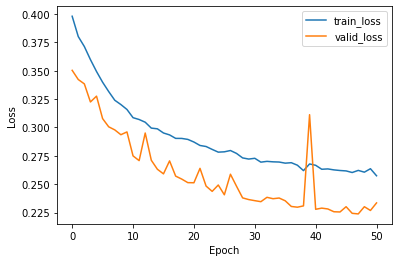

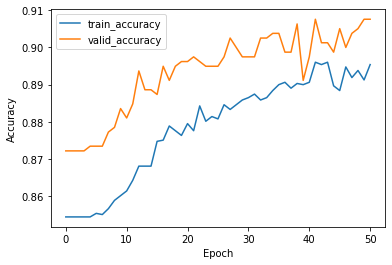

In [22]:
trainer(model, criterion, optimizer, train_loader, valid_loader, epochs=51, patience=5, verbose=True)

# Prediction

Prbability of being Tumor: 0.0501


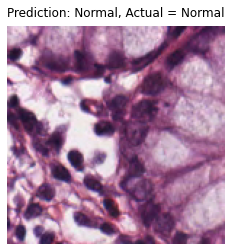

In [23]:
model.eval()
with torch.no_grad():
    img, lab = next(iter(test_loader))
    y_prob = torch.sigmoid(model(img))
    # y_prob = torch.sigmoid(model(img[None, :, :, :][0]))
    y_class = int(y_prob[0] > 0.5)
    classes = ["Normal", "Tumor"]
    print(f"Prbability of being Tumor: {y_prob[0].item():.3g}")
    
    plt.imshow(img[0].permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Prediction: {['Normal', 'Tumor'][y_class]}, Actual = {classes[int(lab[0])]}", pad=10);